In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow as tf

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras.models import load_model
from sklearn.preprocessing import StandardScaler  
from collections import defaultdict
from keras.layers.advanced_activations import LeakyReLU

#leaky_relu = tf.nn.leaky_relu

Using TensorFlow backend.


###  Stocks data (1990 ~ 2019)

In [3]:
stocks = pd.read_csv('C:/Users/dip/Desktop/compu_finance_finalproject/stocks.csv')
stocks = stocks.set_index(pd.DatetimeIndex(stocks['date']))
stocks = stocks.drop(['date'], axis=1)

stocks = stocks[stocks.index.dayofweek < 5] # business day only
stocks_return = stocks.pct_change()

In [4]:
stocks_lp = stocks[2:]
stocks_lp_bf = stocks_lp.fillna(method='bfill')

In [5]:
stocks_return = stocks_return[2:]
stocks_return_mf = stocks_return.fillna(stocks_return.mean())

### Stocks data (1995 ~ 2019)

In [6]:
stocks95 = stocks['1995':]
stocks95_return = stocks95.pct_change()

In [7]:
# 95 last price // 95 stock return dataframe

stocks95_lp = stocks95[2:]
stocks95_lp_zf = stocks95_lp.fillna(0)

stocks95_return = stocks95_return[2:]
stocks95_return_mf = stocks95_return.fillna(0)

### Stocks data (2000 ~ 2019)

In [8]:
stocks00 = stocks['2000':]
stocks00_return = stocks00.pct_change()

In [9]:
# 2000 last price // 2000 stock return dataframe

stocks00_lp = stocks00[2:]
stocks00_lp_zf = stocks00_lp.fillna(0)

stocks00_return = stocks00_return[2:]
stocks00_return_mf = stocks00_return.fillna(0)

###  Stocks data (2015 ~ 2019)

In [10]:
stocks15 = stocks['2015':]
stocks15_return = stocks15.pct_change()

In [11]:
# 2000 last price // 2000 stock return dataframe

stocks15_lp = stocks15[2:]
stocks15_lp_zf = stocks15_lp.fillna(0)

stocks15_return = stocks15_return[2:]
stocks15_return_mf = stocks15_return.fillna(0)

In [12]:
len(stocks15_lp)

1284

In [13]:
stock15 = defaultdict(defaultdict)

stock15['calibrate']['lp'] = stocks15_lp_zf[:642]
stock15['validate']['lp'] = stocks15_lp_zf[642:]

stock15['calibrate']['pct'] = stocks15_return_mf[:642]
stock15['validate']['pct'] = stocks15_return_mf[642:]

###  Kospi data (1990 ~ // 1995 ~ // 2000 ~ )

In [48]:
kospi = pd.read_csv('C:/Users/dip/Desktop/compu_finance_finalproject/kospi.csv')
kospi = kospi.set_index(pd.DatetimeIndex(kospi['date']))
kospi = kospi[kospi.index.dayofweek < 5]
kospi = kospi.drop(['date', 'pct_change'], axis=1)
kospi['pct_change'] = kospi['kospi_index'].pct_change()*100
kospi = kospi.dropna()
kospi = kospi[1:]

In [49]:
kospi95 = kospi['1995':]
kospi00 = kospi['2000':]
kospi15 = kospi['2015':]

In [50]:
# kospi data

kspi15 = defaultdict(defaultdict)

kospi15_lp = kospi15.iloc[2:,0] # Series
kspi15['calibrate']['lp'] = kospi15_lp[:642]
kspi15['validate']['lp'] = kospi15_lp[642:]

kospi15_percentage = kospi15.iloc[2:,2] # Series
kspi15['calibrate']['pct'] = kospi15_percentage[:642]
kspi15['validate']['pct'] = kospi15_percentage[642:]

#  Autoencoder Modeling !!

In [17]:
# Defining Swish Activation Function
def swish(x):
  return x * tf.nn.sigmoid(x)

In [18]:
encoding_dim = 7 # 10 neurons
num_stock = len(stocks15_lp_zf.columns) # Use 791 stocks as features

# connect all layers
input_img = Input(shape=(num_stock, ))
encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
decoded = Dense(num_stock, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded) # see 'Stacked Auto-Encoders' in paper

# construct and compile AE model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

# train autoencoder
data = stock15['calibrate']['pct']
autoencoder.fit(data, data, shuffle=False, epochs=300, batch_size = 10)
#autoencoder.save('model/retrack_autoencoder.h5')

# test/reconstruct market information matrix
#reconstruct = autoencoder.predict(data)

Epoch 1/300
642/642 [==============================] - 1s 892us/step - loss: 0.2724
Epoch 2/300
642/642 [==============================] - 0s 251us/step - loss: 0.2654
Epoch 3/300
642/642 [==============================] - 0s 238us/step - loss: 0.2586
Epoch 4/300
642/642 [==============================] - 0s 244us/step - loss: 0.2520
Epoch 5/300
642/642 [==============================] - 0s 247us/step - loss: 0.2455
Epoch 6/300
642/642 [==============================] - 0s 267us/step - loss: 0.2392
Epoch 7/300
642/642 [==============================] - 0s 255us/step - loss: 0.2331
Epoch 8/300
642/642 [==============================] - 0s 245us/step - loss: 0.2272
Epoch 9/300
642/642 [==============================] - 0s 250us/step - loss: 0.2213
Epoch 10/300
642/642 [==============================] - 0s 261us/step - loss: 0.2157
Epoch 11/300
642/642 [==============================] - 0s 253us/step - loss: 0.2102
Epoch 12/300
642/642 [==============================] - 0s 258us/step - lo

In [19]:
#autoencoder.save('AE_model/retrack_autoencoder.h5')
autoencoder.save('AE_model/retrack_autoencoder_2015_300_1.h5')

In [20]:
# test/reconstruct market information matrix
reconstruct = autoencoder.predict(data)

In [21]:
communal_information = []

for i in range(0,791):
    diff = np.linalg.norm((data.iloc[:,i] - reconstruct[:,i])) # 2 norm difference
    communal_information.append(float(diff))
 
print("stock #, 2-norm, stock name")
ranking = np.array(communal_information).argsort()
for stock_index in ranking:
    print(stock_index, communal_information[stock_index], stock15['calibrate']['pct'].iloc[:,stock_index].name) # print stock name from lowest different to highest

stock #, 2-norm, stock name
102 2.1479891101102577e-05 Lotte Confectionery Co Ltd
496 2.334459871390365e-05 E KOCREF CR-REIT Co Ltd
709 2.8110433958758685e-05 SeAH Steel Corp
110 3.070600112470892e-05 BGF retail Co Ltd
621 3.113134277824182e-05 Tway Air Co Ltd
479 3.124672480413068e-05 Hyosung Chemical Corp
71 3.353757887544134e-05 Hanwha Systems Co Ltd
131 3.692581162720648e-05 Hyundai Autoever Corp
480 3.939983863566516e-05 Hyosung Advanced Materials Corp
501 3.962878130758389e-05 Doosan Solus Co Ltd
774 3.9668792743866984e-05 Air Busan Co Ltd
502 4.041241685476521e-05 Doosan Fuel Cell Co Ltd
666 4.103005464004422e-05 Asiana IDT Inc
124 4.201155534171665e-05 Xi S&D Inc
10 4.315655154193238e-05 KC Tech Co Ltd/New
478 5.009205461122791e-05 Hyosung TNC Co Ltd
16 5.3914017111426695e-05 Aekyung Industrial Co Ltd
642 5.449044939855369e-05 Hana Pharm Co Ltd
648 5.681945163081174e-05 Hanil Cement Co Ltd/New
66 5.7494022866228234e-05 Orion Corp/Republic of Korea
160 6.592151058111334e-05 Jin 

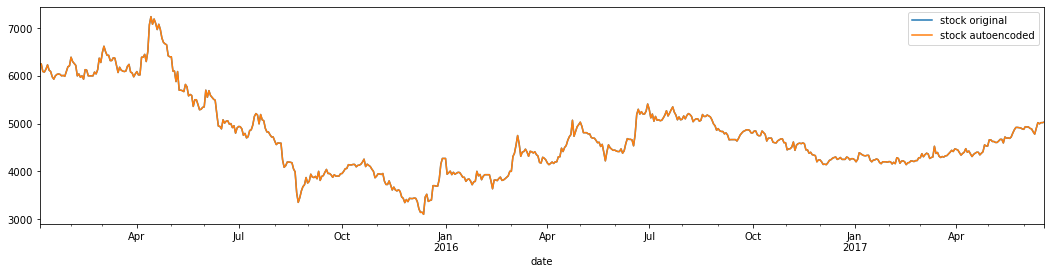

In [37]:
# checking the recovery performance for a single stock
which_stock = 100

# now decoded last price plot
stock_autoencoder = copy.deepcopy(reconstruct[:, which_stock])
stock_autoencoder[0] = 0
stock_autoencoder = stock_autoencoder.cumsum()
stock_autoencoder += (stock15['calibrate']['lp'].iloc[:, which_stock])

## plot for comparison
fig = plt.figure(figsize=(2^16,2^6))
pd.Series(stock15['calibrate']['lp'].iloc[:, which_stock], index=kospi15_lp.index[:642]).plot(label='stock original', legend=True) #index=pd.date_range(start='01/02/1995', periods=2590, freq='D'))
pd.Series(stock_autoencoder, index=kospi15_lp.index[:642]).plot(label='stock autoencoded', legend=True) #index=pd.date_range(start='01/03/1990', periods=780, freq='W')

###  Phase 2 : Calibrating

In [38]:
kspi15_predict = defaultdict(defaultdict)
total_2_norm_diff15 = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock15['calibrate']['pct'].iloc[:, stock_index]
    y = kspi15['calibrate']['pct']
    y = pd.DataFrame(y)
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    #dl_scalery = StandardScaler()
    #dl_scalery.fit(y)
    #y = dl_scalery.transform(z)
    
    
    
    deep_learner.fit(x, y, shuffle=False, epochs=300, batch_size = 10)    # fit the model
    deep_learner.save('AE_model/D7_retrack_2015_300_1' + str(s) + '.h5') # for validation phase use
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['calibrate'][s] = kspi15['calibrate']['lp'][0] * (relative_percentage.cumprod())
    total_2_norm_diff15['calibrate'][s] = np.linalg.norm((kspi15_predict['calibrate'][s] - kspi15['calibrate']['lp']))

Epoch 1/300
642/642 [==============================] - 0s 314us/step - loss: 0.9132
Epoch 2/300
642/642 [==============================] - 0s 225us/step - loss: 0.3678
Epoch 3/300
642/642 [==============================] - 0s 235us/step - loss: 0.2981
Epoch 4/300
642/642 [==============================] - 0s 256us/step - loss: 0.2617
Epoch 5/300
642/642 [==============================] - 0s 349us/step - loss: 0.2365
Epoch 6/300
642/642 [==============================] - 0s 277us/step - loss: 0.2174
Epoch 7/300
642/642 [==============================] - 0s 244us/step - loss: 0.2021
Epoch 8/300
642/642 [==============================] - 0s 224us/step - loss: 0.1895
Epoch 9/300
642/642 [==============================] - 0s 253us/step - loss: 0.1789
Epoch 10/300
642/642 [==============================] - 0s 261us/step - loss: 0.1698
Epoch 11/300
642/642 [==============================] - 0s 311us/step - loss: 0.1619
Epoch 12/300
642/642 [==============================] - 0s 256us/step - lo

S290 2-norm difference:  1357.7322290495515
S480 2-norm difference:  938.72380669122
S670 2-norm difference:  610.2791385411425
Fix Rank: 150
Encoding Dim: 7
Enco Acti: swish
Deco Acti: linear


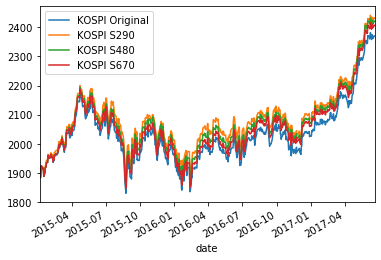

In [39]:
kospi15_plot = pd.DataFrame(kspi15['calibrate']['lp'], index=kospi15_lp.index[:642])
plt.plot(kospi15_plot, label='KOSPI Original')
pd.Series(kspi15_predict['calibrate'][240+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S290')
pd.Series(kspi15_predict['calibrate'][430+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S480')
pd.Series(kspi15_predict['calibrate'][620+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S670')

print("S" + str(240+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][240+50])
print("S" + str(430+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][430+50])
print("S" + str(620+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][620+50])
print("Fix Rank: 150")
print("Encoding Dim: 7")
print("Enco Acti: swish")
print("Deco Acti: linear")

plt.legend()
plt.show()

###  Phase 3 : Validating

In [40]:
    
for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('AE_model/D7_retrack_2015_300_1' + str(s) + '.h5', custom_objects={"swish":swish})
        
    x = stock15['validate']['pct'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['validate'][s] = kspi15['validate']['lp'][0] * (relative_percentage.cumprod())          
    total_2_norm_diff15['validate'][s] = np.linalg.norm((kspi15_predict['validate'][s] - kspi15['validate']['lp']))

S290 2-norm difference:  14423.62360859374
S480 2-norm difference:  8074.787661922043
S670 2-norm difference:  3228.163747467969
Model : D7_retrack_2015_300_1
Dimension : 7


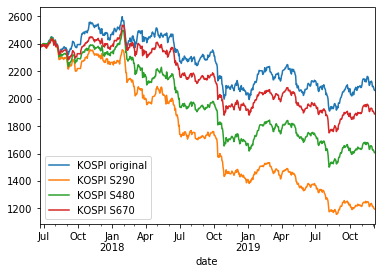

In [41]:
# plot results and 2-norm differences
pd.Series(kspi15['validate']['lp'].values, index=kospi15_lp.index[642:]).plot(label='KOSPI original', legend=True)

for s in [290, 480, 670]: #   
    pd.Series(kspi15_predict['validate'][s], index=kospi15_lp.index[642:]).plot(label='KOSPI S'+str(s), legend=True)
    print("S" +str(s) + " 2-norm difference: ", total_2_norm_diff15['validate'][s])

print("Model : D7_retrack_2015_300_1")
print("Dimension : 7")

### Phase 4 : Verifying

In [42]:
error = []
for non_communal in range(5, 786, 1):  
    
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index


    # training
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x_train = stock15['calibrate']['pct'].iloc[:, stock_index]
    y_train = kspi15['calibrate']['pct']
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x_train)
    x_train = dl_scaler[s].transform(x_train)  
    
    deep_learner.fit(x_train, y_train, shuffle=False, epochs=300, batch_size = 10)    # fit the model


    # testing
    x_test = stock15['validate']['pct'].iloc[:, stock_index]
    y_test = kspi15['validate']['pct']

    x_test = dl_scaler[s].transform(x_test)  
    
    relative_percentage = copy.deepcopy(deep_learner.predict(x_test))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    predict_curve = kspi15['validate']['lp'][0] * (relative_percentage.cumprod())          
    error.append(np.linalg.norm((predict_curve - kspi15['validate']['lp'])))

Epoch 1/300
642/642 [==============================] - 0s 311us/step - loss: 0.6841
Epoch 2/300
642/642 [==============================] - 0s 239us/step - loss: 0.3907
Epoch 3/300
642/642 [==============================] - 0s 228us/step - loss: 0.3333
Epoch 4/300
642/642 [==============================] - 0s 239us/step - loss: 0.3010
Epoch 5/300
642/642 [==============================] - 0s 252us/step - loss: 0.2782
Epoch 6/300
642/642 [==============================] - 0s 272us/step - loss: 0.2604
Epoch 7/300
642/642 [==============================] - 0s 239us/step - loss: 0.2457
Epoch 8/300
642/642 [==============================] - 0s 250us/step - loss: 0.2333
Epoch 9/300
642/642 [==============================] - 0s 258us/step - loss: 0.2225
Epoch 10/300
642/642 [==============================] - 0s 242us/step - loss: 0.2131
Epoch 11/300
642/642 [==============================] - 0s 239us/step - loss: 0.2049
Epoch 12/300
642/642 [==============================] - 0s 239us/step - lo

KeyboardInterrupt: 

Text(0, 0.5, 'number of stocks in the portfolio')

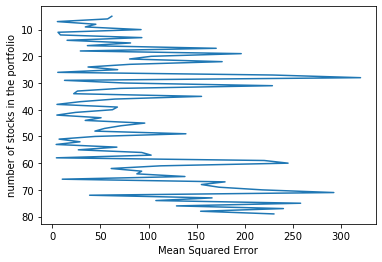

In [169]:
# Plot Efficient Deep Frontier

mse = [e/len(kspi15['validate']['lp']) for e in error] # mse = sum of 2 norm difference/ # of test dates
plt.gca().invert_yaxis()
plt.plot(mse, list(range(5,786,1)))
plt.xlabel('Mean Squared Error')
plt.ylabel('number of stocks in the portfolio')

### Stock Selection that outperforms KOSPI Index

#### amended kospi index

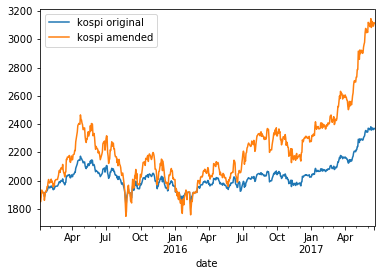

In [51]:
# from -5% to 5%
kspi15_amended = kspi15['calibrate']['pct']
kspi15_amended[kspi15_amended < -3] = 3

# re-calculate the last price
kspi15_amended[0] = 0
relative_percentage = (kspi15_amended /100) + 1
kspi15_lp_amended = kspi15['calibrate']['lp'] * (relative_percentage.cumprod())

# plot comparison
pd.Series(kspi15['calibrate']['lp'].values, index=kospi15_lp.index[:642]).plot(label='kospi original', legend=True) 
pd.Series(kspi15_lp_amended.values, index=kospi15_lp.index[:642]).plot(label='kospi amended', legend=True)

###  Beat KOSPI. Phase 2 : Calibrating

In [52]:
kspi15_predict = defaultdict(defaultdict)
total_2_norm_diff15 = defaultdict(defaultdict)
dl_scaler = defaultdict(StandardScaler)

for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    
    # connect all layers
    input_img = Input(shape=(s,))
    encoded = Dense(encoding_dim, activation=swish, kernel_regularizer=regularizers.l2(0.01))(input_img)
    decoded = Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01))(encoded)
    
    
    # construct and compile deep learning routine
    deep_learner = Model(input_img, decoded)
    deep_learner.compile(optimizer='sgd', loss='mean_squared_error')
    
    x = stock15['calibrate']['pct'].iloc[:, stock_index]
    y = kspi15_amended
    #y = pd.DataFrame(y)
    
    dl_scaler[s] = StandardScaler()       # Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data
    dl_scaler[s].fit(x)
    x = dl_scaler[s].transform(x)  
    
    #dl_scalery = StandardScaler()
    #dl_scalery.fit(y)
    #y = dl_scalery.transform(z)
        
    
    deep_learner.fit(x, y, shuffle=False, epochs=100, batch_size = 10)    # fit the model
    deep_learner.save('Beat_model/D7_beat_2015_100_1' + str(s) + '.h5') # for validation phase use
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['calibrate'][s] = kspi15['calibrate']['lp'][0] * (relative_percentage.cumprod())
    total_2_norm_diff15['calibrate'][s] = np.linalg.norm((kspi15_predict['calibrate'][s] - kspi15_lp_amended))

Epoch 1/100
642/642 [==============================] - 0s 315us/step - loss: 0.8987
Epoch 2/100
642/642 [==============================] - 0s 224us/step - loss: 0.4078
Epoch 3/100
642/642 [==============================] - 0s 227us/step - loss: 0.3263
Epoch 4/100
642/642 [==============================] - 0s 242us/step - loss: 0.2868
Epoch 5/100
642/642 [==============================] - 0s 241us/step - loss: 0.2603
Epoch 6/100
642/642 [==============================] - 0s 261us/step - loss: 0.2403
Epoch 7/100
642/642 [==============================] - 0s 238us/step - loss: 0.2241
Epoch 8/100
642/642 [==============================] - 0s 236us/step - loss: 0.2105
Epoch 9/100
642/642 [==============================] - 0s 256us/step - loss: 0.1991
Epoch 10/100
642/642 [==============================] - 0s 280us/step - loss: 0.1893
Epoch 11/100
642/642 [==============================] - 0s 264us/step - loss: 0.1808
Epoch 12/100
642/642 [==============================] - 0s 258us/step - lo

S290 2-norm difference:  3496.9983512495055
S480 2-norm difference:  3879.6228902630332
S670 2-norm difference:  3963.3423088929326
Fix Rank: 150
Encoding Dim: 7
Enco Acti: swish
Deco Acti: linear


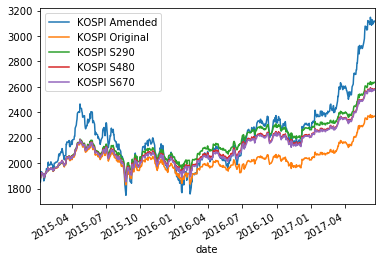

In [53]:
kospi15_plot = pd.DataFrame(kspi15['calibrate']['lp'], index=kospi15_lp.index[:642])
kospi15_plot_lp_amended = pd.DataFrame(kspi15_lp_amended, index=kospi15_lp.index[:642])
plt.plot(kospi15_plot_lp_amended, label='KOSPI Amended')
plt.plot(kospi15_plot, label='KOSPI Original')

pd.Series(kspi15_predict['calibrate'][240+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S290')
pd.Series(kspi15_predict['calibrate'][430+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S480')
pd.Series(kspi15_predict['calibrate'][620+50], index=kospi15_lp.index[:642]).plot(label='KOSPI S670')

print("S" + str(240+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][240+50])
print("S" + str(430+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][430+50])
print("S" + str(620+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][620+50])
print("Fix Rank: 150")
print("Encoding Dim: 7")
print("Enco Acti: swish")
print("Deco Acti: linear")

plt.legend()
plt.show()

### Beat KOSPI. Phase 3 : Validation

In [46]:

for non_communal in [140, 330, 520]:  
    # some numerical values
    encoding_dim = 7
    s = 150 + non_communal
    stock_index = np.concatenate((ranking[0:150], ranking[-non_communal:])) # portfolio index
    
    # load our trained models
    deep_learner = load_model('Beat_model/D7_beat_2015_50_1' + str(s) + '.h5', custom_objects={"swish":swish})
        
    x = stock15['validate']['pct'].iloc[:, stock_index]
    x = dl_scaler[s].transform(x)  
    
    # is it good?
    relative_percentage = copy.deepcopy(deep_learner.predict(x))
    relative_percentage[0] = 0
    relative_percentage = (relative_percentage /100) + 1
    
    kspi15_predict['validate'][s] = kspi15['validate']['lp'][0] * (relative_percentage.cumprod())          
    #total_2_norm_diff15['validate'][s] = np.linalg.norm((kspi15_predict['validate'][s] - kspi15['validate']['lp']))

Fix Rank: 150
Encoding Dim: 7
Enco Acti: swish
Deco Acti: linear


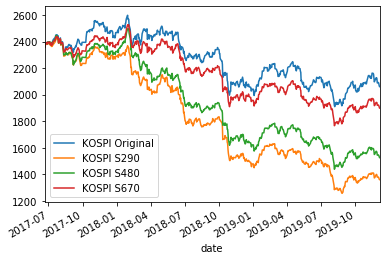

In [47]:
kospi15_plot = pd.DataFrame(kspi15['validate']['lp'], index=kospi15_lp.index[642:])
kospi15_plot_lp_amended = pd.DataFrame(kspi15_lp_amended, index=kospi15_lp.index[642:])
#plt.plot(kospi15_plot_lp_amended, label='KOSPI Amended')
plt.plot(kospi15_plot, label='KOSPI Original')

pd.Series(kspi15_predict['validate'][240+50], index=kospi15_lp.index[642:]).plot(label='KOSPI S290')
pd.Series(kspi15_predict['validate'][430+50], index=kospi15_lp.index[642:]).plot(label='KOSPI S480')
pd.Series(kspi15_predict['validate'][620+50], index=kospi15_lp.index[642:]).plot(label='KOSPI S670')

#print("S" + str(240+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][240+50])
#print("S" + str(430+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][430+50])
#print("S" + str(620+50) + " 2-norm difference: ", total_2_norm_diff15['calibrate'][620+50])
print("Fix Rank: 150")
print("Encoding Dim: 7")
print("Enco Acti: swish")
print("Deco Acti: linear")

plt.legend()
plt.show()